# ECG generation via Gaussian processes.

Here is an attempt to use Gaussian Processes (GP) to generate ECG signals.
So far the GP was considered for denoising and filtering. 

The idea is the following: 

1. Generate a heartbeat (i.e. a PQRST waveform) via a function Gaussian processes on the [-pi, pi] interval.

2. Consider the posterior distribution conditioned over some PQRST points for which the corresponding positions and values (i.e. amplitudes) (which are the model's parameters) are taken from McSharry & Sameni articles.

3. The obtained signal represents a heartbeat. 

4. For any circle, consider the conditioning w.r.t. to PQRST points that vary, i.e.  
    4.1. PQRST observed location,  
    4.2. PQRST observed amplitudes  
are r.v. themselves.

5. The result is a curve issued from a statistical model for which each segment is the realization of a GP with some kernel correspondng parameters (sigma and l, to be discussed later, those too can vary but for now they don't) and some "varying" parameters that simply controls the "meta" distribution, i.e. the distribution's parameters gouverning  
    5.1. the baseline mean,  
    5.2. the obsertvation locations,  
    5.3. the amplitude observations.  

More preceisely:
*  FUNC_1 (P_pos, P_amp, ..., T_pos, T_amp) -> a function outputting a heart beat signal which necessarily hits PQRST points
*  FUNC_2 -> FUNC_1 parameters are varied accordingly for each heartbeat. 

By concatenation a quasiperiodic signal is produced - the observation times and the observed values are just realization of a chosen law around the "canonical" means, stated in McSharry & Sameni.

The model is a Normal model, i.e. w.r.t. the canonical values stated in the articles I consider a realization from a normal distribution with that specific mean and a (small) variance. 

A discussion about this choice is in order. Clearly, if i want the baseline to be smooth as in baseline mean between segements to not have sudden drops, other distributons can be used. 

Also, it can be improved by actually considering multivariate distribution (bear in mind that obs_vals and obs_time are actually vectors so i can inject some correlations also) but for now that is what it was implemented.

The chalenge is to find sufficent large variances to give the signal the realistic unperiodic form but suffiently small not to have big unnatural variations.

Other parameters: 

* mu_p - what i call prior mean, helps model the signal's baseline variation.

* sigma and l -  kernel's parameters.

This is nothing new, in the sense that, indirectly, the way the guys in the article do the filtering is to assume that s(t) (i.e. the pure ECG signal) is following a Gaussian process. But different from then, I use this model in order to generate ECG beats and then ECG signals.


## Gaussian processes

In [1]:
import numpy as np
import random as rnd
from numpy.linalg import inv
import matplotlib.pyplot as plt

In [2]:
def func_k(pitime, sigma, l):
    #print(" -> launched func_k( ,",sigma,",",l,")")
    kr = []
    for i in range(len(pitime)):
        cov_val = sigma * np.exp(-1/2* ((pitime - pitime[i])**2/(l**2)))
        kr.append(cov_val)    
    kernel = np.asmatrix(kr)
    return(kernel)

In [3]:
def func_kernels(pitime, sigma_vals, l_vals):
    k_kers = []
    for sigma in sigma_vals:    
        for l in l_vals: 
            #print("sigma = ", sigma, "l = ", l)
            k_ker = func_k(pitime, sigma, l)
            k_kers.append(k_ker)
    return(k_kers)

In [4]:
def func_GP(mu_prior, cov_prior, N_samp_prior):
    samples_prior = np.random.multivariate_normal(mean = mu_prior, cov = cov_prior, size = N_samp_prior)
    samples_prior = np.transpose(samples_prior)
    return(samples_prior)

In [5]:
def func_obs_time(obs_pitime):
    res = []
    for val in obs_pitime:
        posval = np.where(abs(pitime-val) == min(abs(pitime-val)))[0]
        res.append(posval[0])    
    return(np.asarray(res))

In [6]:
def func_ABC(cov_prior, un_time, obs_time):
    A = cov_prior[un_time,:]
    A = A[:,un_time]

    B = cov_prior[obs_time,:]
    B = B[:,obs_time]

    C = cov_prior[un_time,:]
    C = C[:,obs_time]

    return(A,B,C)

In [7]:
def func_GP_post(mu_post, cov_post, N_samp_post):  
    un_val = func_GP(mu_post, cov_post, N_samp_post)
    sample_post = [0] * (len(obs_time) + len(un_time))
    for i in range(len(obs_time)):    
        sample_post[obs_time[i]] = np.array([obs_value[i]]* N_samp_post)
    for j in range(len(un_time)):    
        sample_post[un_time[j]] = un_val[j]   
    sample_post =  np.array(sample_post)
    return(sample_post)

In [8]:
def func_plot_GPPost1(pitime, sample_post, obs_pitime, obs_value):    
    plt.plot(pitime, sample_post)
    plt.plot(obs_pitime, obs_value,'ob')    

In [9]:
def func_GP_post_mean_cov(A, B, C, mu_prior, obs_time, un_time, obs_value):
    mu = np.array(mu_prior)

    mu_obs = mu[obs_time]
    mu_un = mu[un_time]
        
    mu_pos = mu_un.reshape(-1,1) + C * inv(B) * (obs_value - mu_obs).reshape(-1,1)
    mu_pos = mu_pos.tolist()
    mu_post = []
    for l in mu_pos:
        mu_post.extend(l)
    
    cov_post = A - C * inv(B) * C.T
    return (mu_post, cov_post)

In [10]:
def func_rand_vec(vec, var):
    vec_rand = vec
    for j in range(len(vec)):
        vec_rand[j] = np.random.normal(vec[j], var, 1)
    return(vec_rand)

In [11]:
def func_rand_param(mu_p, var_mu_p, pitime, sigma, l, obs_pitime, var_obs_pitime, obs_value, var_obs_value):
    mu_p_rand = np.random.normal(mu_p, var_mu_p, 1)
    mu_prior = [mu_p_rand] * len(pitime)

    k_ker = func_k(pitime, sigma, l)    
    
    obs_pitime_rand = func_rand_vec(obs_pitime, var_obs_pitime)    
    obs_value_rand = func_rand_vec(obs_value, var_obs_value)
    
    obs_time_rand = func_obs_time(obs_pitime_rand)
    un_time_rand = [i for i in time if i not in obs_time]        
    
    A,B,C = func_ABC(k_ker, un_time_rand, obs_time_rand)
    mu_post, cov_post = func_GP_post_mean_cov(A, B, C, mu_prior, obs_time_rand, un_time, obs_value_rand)        
    
    return(mu_post, cov_post)

In [12]:
def func_pitime_ecg(pitime, n_hb):    
    pitime_ecg = np.array([])
    for i in np.arange(n_hb):
        pitime_c = i * (pitime[-1] - pitime[0]) + pitime
        pitime_ecg = np.concatenate((pitime_ecg,pitime_c))
    return(pitime_ecg)

In [13]:
#fs = 1000
#N = 2 * np.pi * fs
N = 1440
time = np.arange(N)
pitime = -np.pi + 2 * np.pi * time / N

In [14]:
# Setting the values of sigma and l appearing in the covariance function
sigma_vals = [0.01, 0.001, 0.0001, 0.00001]
l_vals = [0.5, 0.1, 0.05, 0.01]

# Setting the values of sigma and l appearing in the covariance function
mu_p = -0.2 # One can chose the value of the prior mean
mu_prior = [mu_p] * len(time)

In [15]:
k_kers = func_kernels(pitime, sigma_vals,l_vals)

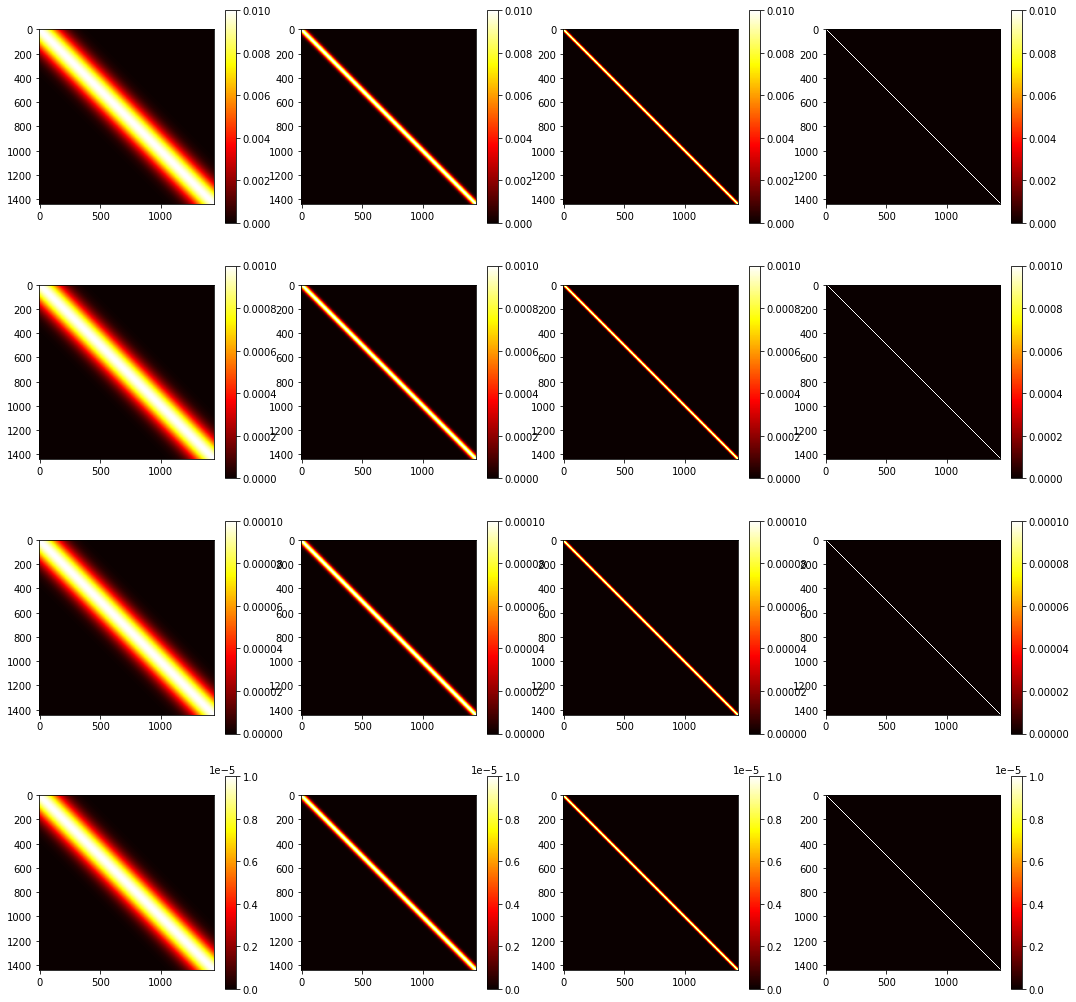

In [16]:
plt.figure(figsize=(18,18))
columns = len(l_vals)
rows = len(sigma_vals)
for i, k_ker in enumerate(k_kers):
    plt.subplot(rows, columns, i + 1)
    plt.imshow(k_ker, cmap='hot', interpolation = 'nearest')
    plt.colorbar()

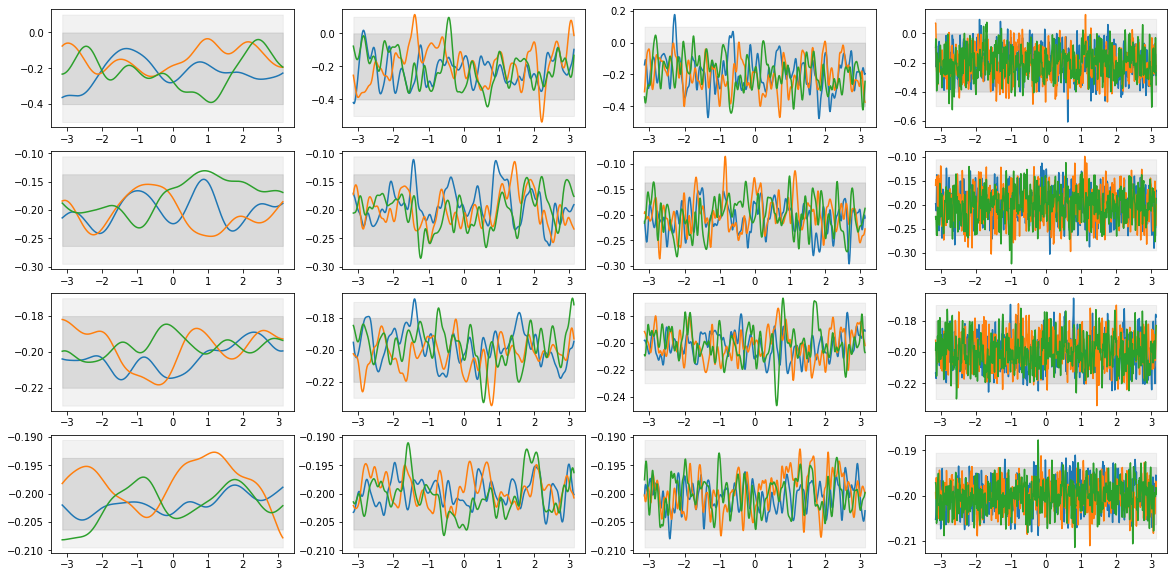

In [17]:
plt.figure(figsize=(20,10))
rows = len(sigma_vals)
columns = len(l_vals)
for i, k_ker in enumerate(k_kers):
    samples = func_GP(mu_prior, k_ker, 3)
    plt.subplot(rows, columns, i + 1)
    plt.plot(pitime, samples)
    plt.fill_between(pitime, 
                     mu_prior - 2 * np.sqrt(np.diag(k_ker)), 
                     mu_prior + 2 * np.sqrt(np.diag(k_ker)), 
                     color='gray', 
                     alpha=0.2)
    plt.fill_between(pitime, 
                     mu_prior - 3 * np.sqrt(np.diag(k_ker)), 
                     mu_prior + 3 * np.sqrt(np.diag(k_ker)), 
                     color='gray', 
                     alpha=0.1)    

In [18]:
obs_pitime = [-np.pi/3, -np.pi/12, 0, np.pi/12, np.pi/2]
obs_value = [0.2,-0.35, 1.2, -0.44, 0.36]
mu = np.array(mu_prior)

obs_time = func_obs_time(obs_pitime)
un_time = [i for i in time if i not in obs_time]

#mu_obs = mu[obs_time]
#mu_un = mu[un_time]

#mu_pos = mu_un.reshape(-1,1) + C * inv(B) * (obs_value - mu_obs).reshape(-1,1)
#mu_pos = mu_pos.tolist()
#mu_post = []
#for l in mu_pos:
#    mu_post.extend(l)

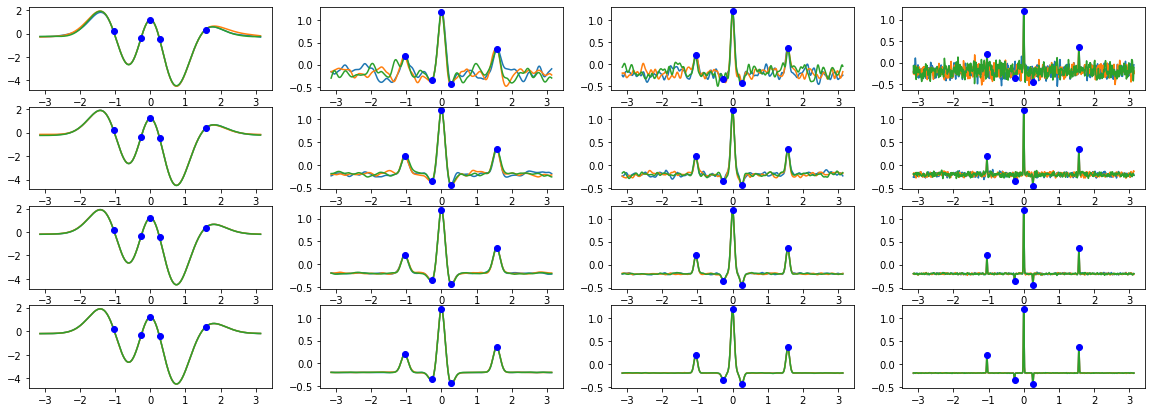

In [19]:
plt.figure(figsize=(20,7))
rows = len(l_vals) 
columns = len(sigma_vals)
for i, k_ker in enumerate(k_kers):
    A,B,C = func_ABC(k_ker, un_time, obs_time)
    mu_post, cov_post = func_GP_post_mean_cov(A, B, C, mu_prior, obs_time, un_time, obs_value)
    sample_post = func_GP_post(mu_post, cov_post, 3)
    plt.subplot(rows, columns, i + 1)
    func_plot_GPPost1(pitime, sample_post, obs_pitime, obs_value)

## An ECG heartbeat

In [20]:
N = 1440
time = np.arange(N)
pitime = -np.pi + 2 * np.pi * time / N

In [21]:
sigma = 0.001
l = 0.05
mu_p = -0.2 # One can chose the value of the prior mean

k_ker = func_k(pitime, sigma, l)
mu_prior = [mu_p] * len(time)

In [22]:
obs_pitime = [-np.pi/3, -np.pi/12, 0, np.pi/12, np.pi/2]
obs_value = [0.2,-0.35, 1.2, -0.44, 0.36]
#mu = np.array(mu_prior)

obs_time = func_obs_time(obs_pitime)
un_time = [i for i in time if i not in obs_time]

In [23]:
samples = func_GP(mu_prior, k_ker, 3)

A,B,C = func_ABC(k_ker, un_time, obs_time)
mu_post, cov_post = func_GP_post_mean_cov(A, B, C, mu_prior, obs_time, un_time, obs_value)    
sample_post = func_GP_post(mu_post, cov_post, 3)

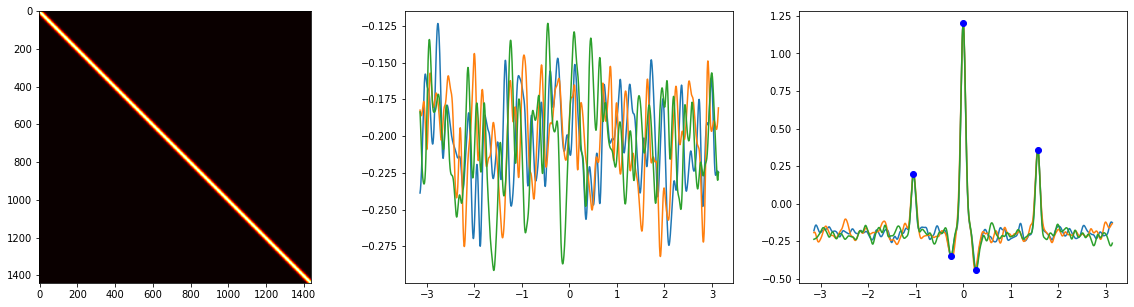

In [24]:
plt.figure(figsize=(20,5))

plt.subplot(1, 3, 1)
plt.imshow(k_ker, cmap='hot', interpolation = 'nearest')

plt.subplot(1, 3, 2)
plt.plot(pitime, samples)
#plt.fill_between(pitime, 
#                 mu_prior - 2 * np.sqrt(np.diag(k_ker)), 
#                 mu_prior + 2 * np.sqrt(np.diag(k_ker)), 
#                 color='gray', 
#                 alpha=0.2)

plt.subplot(1, 3, 3)
func_plot_GPPost1(pitime, sample_post, obs_pitime, obs_value)
plt.show()

## An ECG signal

In [25]:
#number of heart beats
n_hb = 10
ecg = [] 
mu_p = -0.2          # One can chose the value of the prior mean
obs_pitime = [-np.pi/3, -np.pi/12, 0, np.pi/12, np.pi/2]
obs_value = [0.2,-0.35, 1.2, -0.44, 0.36]

for i in np.arange(n_hb):
    
    mu_p_rand = np.random.normal(mu_p, .01, 1)
    k_ker = func_k(pitime, sigma, l)
    mu_prior = [mu_p_rand] * len(time)
    
    obs_pitime_rand = func_rand_vec(obs_pitime, 0.01)    
    obs_value_rand = func_rand_vec(obs_value, 0.001)
    
    obs_time_rand = func_obs_time(obs_pitime_rand)
    un_time_rand = [i for i in time if i not in obs_time]        
    
    A,B,C = func_ABC(k_ker, un_time_rand, obs_time_rand)
    mu_post, cov_post = func_GP_post_mean_cov(A, B, C, mu_prior, obs_time_rand, un_time, obs_value_rand)    
    sample_post = func_GP_post(mu_post, cov_post, 1)
    ecg = np.concatenate((ecg, sample_post), axis=None)

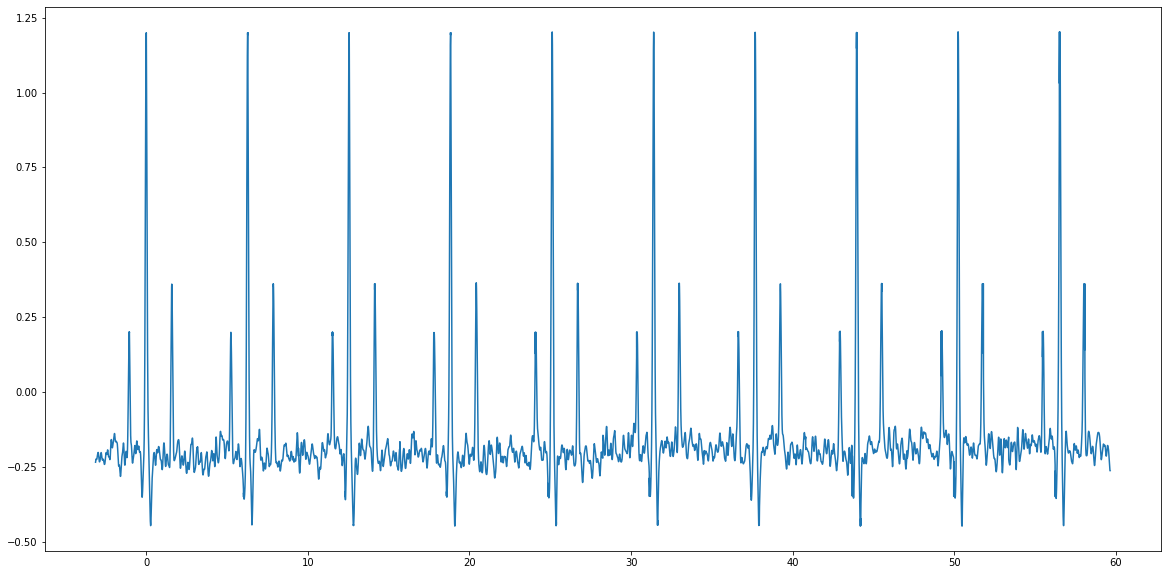

In [26]:
plt.figure(figsize=(20,10))
plt.plot(func_pitime_ecg(pitime, n_hb),ecg)
plt.show()

In [27]:
n_hb = 10
ecg2 = []

sigma = 0.001
l = 0.05
mu_p = -0.2          # One can chose the value of the prior mean

obs_pitime = [-np.pi/3, -np.pi/12, 0, np.pi/12, np.pi/2]
obs_value = [0.2,-0.35, 1.2, -0.44, 0.36]

for i in np.arange(n_hb):    
    mu_post, cov_post = func_rand_param(mu_p, .05, 
                                        pitime, sigma, l, 
                                        obs_pitime, .01, 
                                        obs_value, .05)
    one_heart_beat = func_GP_post(mu_post, cov_post, 1)
    ecg2 = np.concatenate((ecg2, one_heart_beat), axis=None)

In [28]:
pitime_ecg = np.array([])
for i in np.arange(n_hb):
    pitime_c = i * (pitime[-1] - pitime[0]) + pitime
    pitime_ecg = np.concatenate((pitime_ecg,pitime_c))

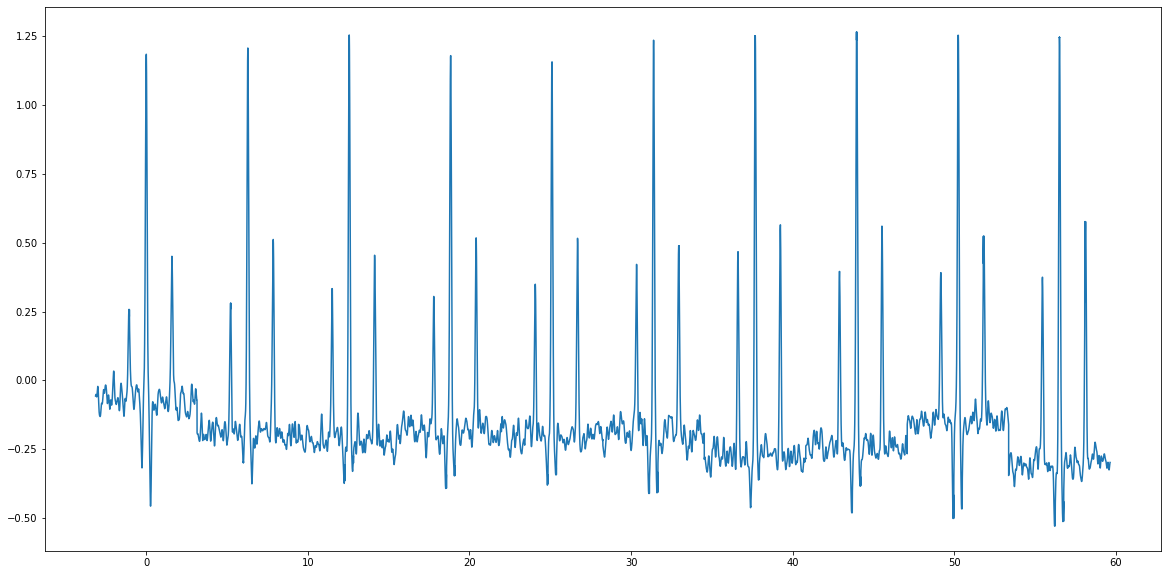

In [29]:
plt.figure(figsize=(20,10))
plt.plot(pitime_ecg,ecg2)
plt.show()

## An ECG synthetic signal (quasi-periodic)

This is the final cell.
Nothing else is required to be loaded (executed) except the first cells containing function definitions.

The significance of parameters is the following:

1. fs - sampling frequency, can be setted to any value, it simply increases the time of computations as increased, 100 or 300 works fast enough, 500 half a minute.

2. time and pitime - just the corresponding time (beats) on the circle. The way it was implemented the pseudo-periodicity wouldn't have required this particular choice [-pi, pi] since the way we do it is but concatenating heart beats and assure a non-strict periodicity by stochasticity. For now I keep it like this, later for a smooth more clear code can be [-1, 1] or even [0,1] with the mention that the locations of observations on circle will have to change. 

3. n_hb - number of heart beats in the synthetic ECG signal we generate.

4. sigma and l - Note Bene: those two parametetrs are related to the Gaussian process  
    4.1. l will fine tune how jiggly the curves i want to be
    4.1. sigma will fine tune how tight i want the signal around the mean (baseline) to be. (see figures above, that is their scope, to graps quickly the influence of l and sigma over the GP-generated curves)

5. obs_pitime - the TIMES (i.e. locations on circle) the observation occured

6. obs_vals - the VALUES (i.e. amplitudes of signal) that were observed

7. _func_rand_param_ - it generated the mean and covariance matrix of the posterior distribution that is used for modelling a heart beat. _mu_p_ is the prior mean of the signal (again, baseline) and the numerical values are  
    7.1 the variance of this mean  
    7.2 the variance around the obs_pitime (i.e. how much variation we allow for different segments, like RR and so on)  
    7.3 the variance around the observations (i.e. how much variation we allow over the amplitudes)

It is the set formed with these three numerical values in the arguments of _func_rand_param_ that shape the curve.


In [30]:
fs = 100
N = np.int(np.floor(2 * np.pi * fs))
time = np.arange(N)
pitime = -np.pi + 2 * np.pi * time / N

n_hb = 10 # number of heart beats
rand_ecg = []

sigma = 0.001
l = 0.05

mu_p = -0.2          # One can chose the value of the prior mean

obs_pitime = [-np.pi/3, -np.pi/12, 0, np.pi/12, np.pi/2]
obs_value = [0.2,-0.35, 1.2, -0.44, 0.36]


obs_time = func_obs_time(obs_pitime)
un_time = [i for i in time if i not in obs_time]

for i in np.arange(n_hb):    
    mu_post, cov_post = func_rand_param(mu_p, .05, 
                                        pitime, sigma, l, 
                                        obs_pitime, .01, 
                                        obs_value, .05)
    one_heart_beat = func_GP_post(mu_post, cov_post, 1)
    rand_ecg = np.concatenate((rand_ecg, one_heart_beat), axis=None)

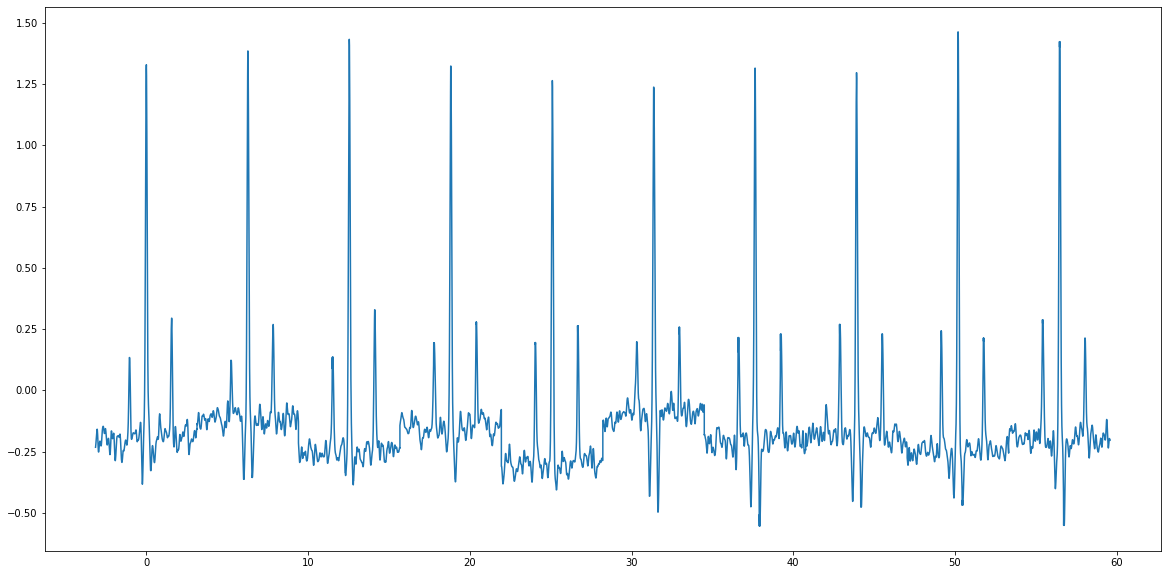

In [32]:
plt.figure(figsize=(20,10))
plt.plot(func_pitime_ecg(pitime, n_hb),rand_ecg)
plt.show()